In [1]:
from IPython.display import Image

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [2]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 준비합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 클래스별로 샘플을 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor=None if idx==1 else 'black',
                    marker=markers[idx], 
                    label=cl)

# 5.3 커널 PCA를 사용하여 비선형 매핑
* 훈련 데이터에 잡음이 있으면 선형적으로 완벽하게 분리되지 못한다.
    * 아달린, 로지스틱 회귀, (기본) SVM
* 비선형 문제
    * PCA와 LDA 같은 차원 축소를 위한 선형 변환 기법은 좋지 않다.
    * PCA의 커널화 버전 or KPCA - 선형적으로 구분되지 않는 데이터를 선형 분류기에 적합한 새로운 저차원 부분 공간으로 변환.



In [3]:
# 선형 문제와 비선형 문제
Image(url='https://git.io/JtsvB', width=500) 

### 5.3.1 커널 함수와 커널 트릭
1. 커널 PCA를 통한 비선형 매핑을 수행하여 데이터를 고차원 공간으로 변환.
2. 고차원 공간에 표준 PCA를 사용하여 샘플이 선형 분류기로 구분될 수 있는 저차원 공간으로 데이터 투영
* 계산 비용이 매우 비싸다.
    * **커널 트릭** - 원본 특성 공간에서 두 고차원 특성 벡터의 유사도 계산

#### 커널 함수 - 두 벡터 사이의 점곱을 계산할 수 있는 함수
* 유사도 측정
* 커널 종류
    * 다항 커널
    * 하이퍼볼릭 탄젠트(hyperbolic tangent) (시그모이드(sigmoid)) 커널
    * 방사 기저 함수(Radial Basis Function, RBF) 또는 가우시안 커널
    

### 5.3.2 파이썬 커널 PCA 구현

In [4]:
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현
    * 매개변수
        - X : numpy.ndarray, shape = [n_samples, n_features]
        - gamma : float, RBF 커널 튜닝 매개변수
        - n_components : list, 변환할 주성분 개수
    * 반환값
        - X_pc : numpy.ndarray, shape = [n_samples, n_features], 투영된 데이터셋
    """
    # M * N 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간의 거리를 정방 대칭 행렬로 변환
    mat_sq_dists = squareform(sq_dists)

    # 커널 행렬을 계산
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞춤
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고유값과 고유벡터를 구한다
    # scipy.linalg.eigh 함수는 오름차순으로 반환
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k개의 고유벡터를 선택(결과값은 투영된 샘플)
    X_pc = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    return X_pc

차원 축소에 RBF 커널 PCA를 사용하는 단점은 사전에  $\gamma$ 매개변수를 지정해야 한다는 것이다. 적절한 $\gamma$ 값을 찾으려면 GridSearchCV 같은 매개변수 튜닝을 위한 알고리즘을 사용하는 것이 좋다.

#### 반달 모양 구분


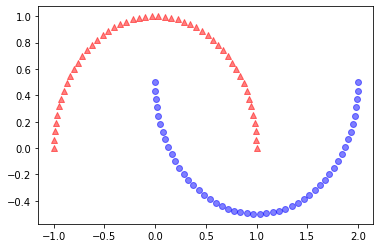

In [5]:
# 두 개의 반달 모양을 띤 100개의 샘플로 구성된 2차원 데이터셋
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

이 반달 모양 데이터셋은 선형적으로 구분되지 않는다. 커널 PCA로 반달 모양을 펼쳐 선형 분류기에 적합한 입력 데이터셋으로 만든다.

* 기본 PCA의 주성분에 데이터셋 투영

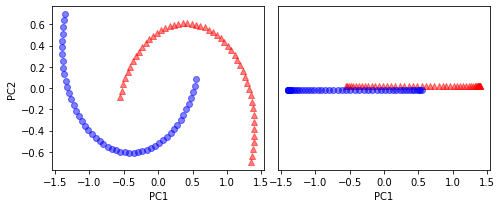

In [6]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

기본 PCA로 변환된 데이터셋을 선형 분류기가 잘 구분할 수 없을 것 같다. 왼쪽 그래프를 보면 원래 반달 모양이 조금만 변경되고 수직축을 기준으로 반전되었다. 이 변환은 동그라미와 삼각형 사이를 판별하는 선형 분류기에 도움이 되지 않는다.

* 커널 PCA 함수 rbf_kernel_pca를 적용

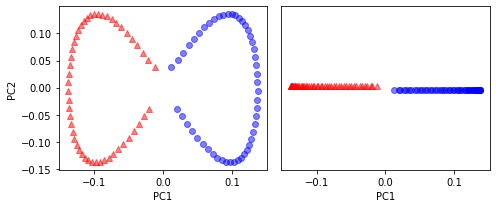

In [7]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

두 클래스인 동그라미와 삼각형 모두 선형적으로 구분이 잘 되므로 선형 분류기를 위한 훈련 데이터로 적합하다.

#### 동심원 분리

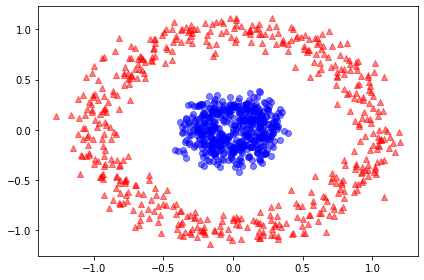

In [8]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

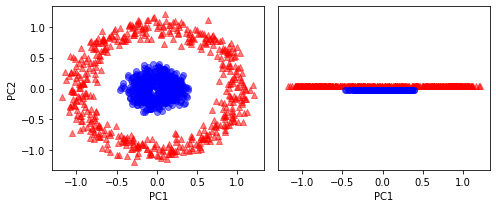

In [9]:
# 기본 PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

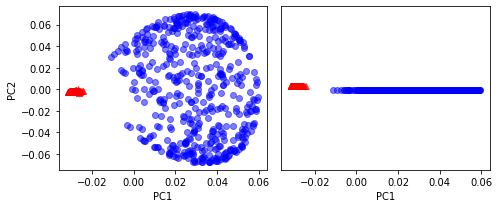

In [10]:
# 적절한 gamma 값을 주고 RBF 커널 PCA 구현
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

RBF 커널 PCA가 두 클래스를 선형적으로 구분할 수 있는 새로운 부분 공간으로 데이터를 투명했다.

### 5.3.3 새로운 데이터 포인트 투영
새로운 샘플과 훈련 데이터셋의 샘플 간 유사도를 계산한 후 고유값으로 고유 벡터 $a$를 정규화해야 한다. rbf_kernel_pca 함수를 커널 행렬의 고유값도 반환하도록 수정한다.

In [11]:
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현
    * 반환값
        - alpha : numpy.ndarray, shape=[n_samples, k_features]
        - lambdas : list, 고유값
    """
    # M * N 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간의 거리를 정방 대칭 행렬로 변환
    mat_sq_dists = squareform(sq_dists)

    # 커널 행렬을 계산
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞춤
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고유값과 고유벡터를 구한다
    # scipy.linalg.eigh 함수는 오름차순으로 반환
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k개의 고유벡터를 선택(투영 결과)
    alphas = np.column_stack([eigvecs[:, i] for i in range(n_components)])

    # 고유 벡터에 상응하는 고유값을 선택
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

새로운 반달 데이터셋을 만들고 수정된 커널 PCA 구현을 사용하여 1차원 부분 공간에 투영한다.

In [12]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

새로운 샘플을 구현하는 코드를 구현하기 위해 반달 데이터셋의 26번째 포인트가 새로운 데이터 포인트 x`라고 가정한다. 이 포인트를 새로운 부분 공간으로 투영하는 작업이다.

In [13]:
x_new = X[25]
x_new

array([1.8713187 , 0.00928245])

In [14]:
x_proj = alphas[25] # 원본 투영
x_proj

array([0.07877284])

In [15]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row) ** 2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# 새로운 데이터포인트를 투영
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([0.07877284])

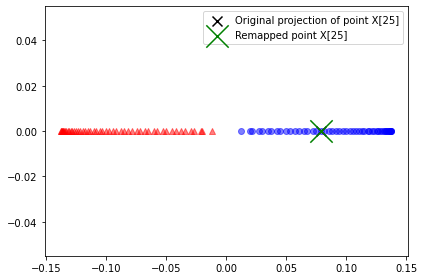

In [16]:
# 첫 번째 주성분에 투영한 것을 시각화
plt.scatter(alphas[y==0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='Original projection of point X[25]', marker='x', s=100)
plt.scatter(x_reproj, 0, color='green', label='Remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
plt.show()

샘플 x`가 첫 번째 주성분에 올바르게 매핑되었다.

### 5.3.4 사이킷런의 커널 PCA

    from sklearn.decomposition import KernelPCA
    kernel 매개변수 = 커널 종류


In [17]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

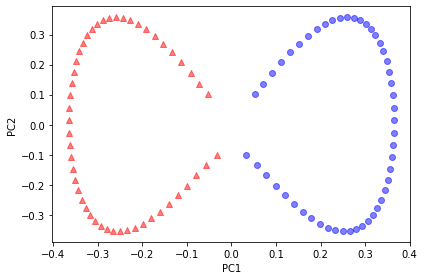

In [18]:
# 변환된 반달 모양 데이터를 처음 두 개의 주성분 시각화
plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

* 사이킷런의 매니폴드 학습(manifold learning)
    * 비선형 차원 축소를 위한 고급 기법
    * 반달 모양 데이터셋과 동심원 데이터셋 적용

In [19]:
def plot_manifold(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], 
                color='red', marker='^', alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1],
                color='blue', marker='o', alpha=0.5)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()

지역 선형 임베딩(Locally Linear Embedding, LLE)은 이웃한 샘플 간의 거리를 유지하는 저차원 투영을 찾는다. 지역 선형 임베딩을 구현한 사이킷런의 `LocallyLinearEmbedding` 클래스를 반달 모양 데이터셋에 적용.

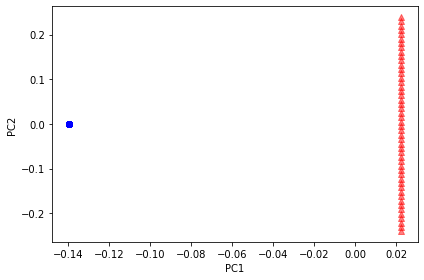

In [20]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=1)
X_lle = lle.fit_transform(X)
plot_manifold(X_lle, y)

반달 모양은 유지되지 않았지만 두 클래스가 뚜렷하게 구분되었다.

* t-SNE 알고리즘(t-distributed Stochastic Neighbor Embedding)
    * 데이터 포인트 간의 유사도 결합 확률(joint probability)로 변환하고, 저차원과 고차원의 확률 사이에서 쿨백-라이블러(Kullback-Leibler) 발산을 최소화.
    * 특히 고차원 데이터셋을 시각화하는데 뛰어난 성능을 낸다.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


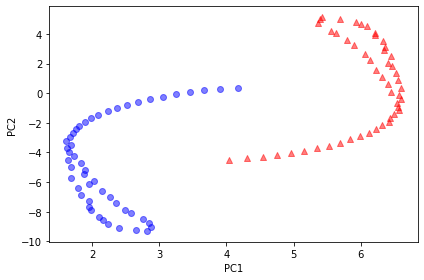

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

plot_manifold(X_tsne, y)

t-SNE는 두 클래스를 선형적으로 구분할 수 있을 정도로 잘 분리되었고 우너래 반달 모양도 어느 정도 유지하고 있다. 

* `KernelPCA`, `LocallyLinearEmbedding`, `TSNE`를 동심원 데이터셋에 적용.

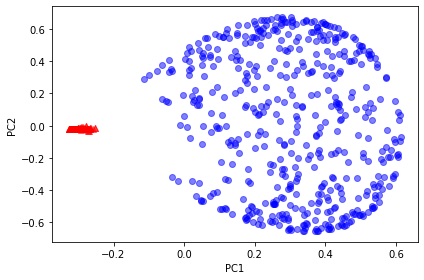

In [22]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

# KernelPCA
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plot_manifold(X_skernpca, y)

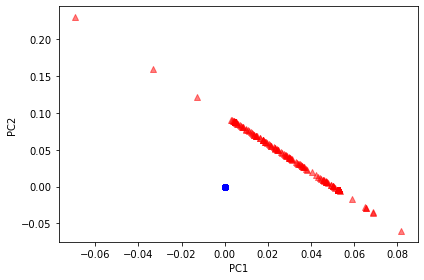

In [23]:
from sklearn.manifold import LocallyLinearEmbedding

# LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, random_state=1)
X_lle = lle.fit_transform(X)

plot_manifold(X_lle, y)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


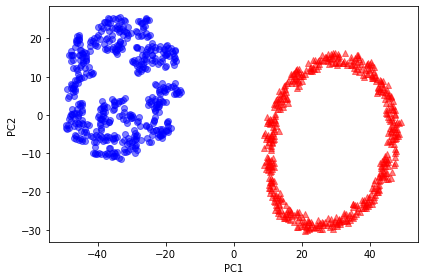

In [24]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

plot_manifold(X_tsne, y)